In [41]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

### Recent K commits 

In [42]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2024-1-1", k=30):
    df = pd.read_csv(csv_file)
    
    # Drop rows where 'date' is null to avoid NaT values
    df = df.dropna(subset=['date'])
    
    # If DataFrame is empty after dropping null dates, skip this file
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)
    
    # Focus on the most recent k commits
    if len(df) > k:
        df = df.iloc[-k:]
    
    df['interval'] = df['timestamp'].diff().dt.total_seconds()
    
    # Calculate the mean and standard deviation of commit intervals
    mean_interval = df['interval'].mean()
    sd_interval = df['interval'].std()
    
    Z = df['interval'].max()
    percentile_95 = df['interval'].dropna().quantile(0.95)
    T = pd.to_datetime(current_time)
    T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
    time_since_last_commit_days = T_X_n / (60 * 60 * 24)
        
    classification = "unknown"
    if T_X_n  > Z*2:
        # Reclassify as "alive" if within a certain SD from the mean
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
        else:
            classification = "dead"
    elif T_X_n < percentile_95:
        classification = "alive"
        
    mean_interval= mean_interval / (60 * 60 * 24)
    
    repo_name = os.path.basename(csv_file).split('.')[0]
    return {
        'Repo': repo_name,
        'Z': Z,
        'T_X_n': T_X_n,
        'Percentile_95': percentile_95,
        'MeanInterval(days)': mean_interval,
        'SDInterval': sd_interval,
        'Classification': classification,
        'TimeSinceLastCommit(days)': time_since_last_commit_days
    }

folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData'  
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)


C:\Users\ethan\AppData\Local\Temp\ipykernel_7180\3545941359.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_7180\3545941359.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


In [43]:
results_df.head(1)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,989884.8,1.588616,360444.837056,dead,858.4439


In [45]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1751.000000
mean      731.497174
std       932.519463
min         1.510486
25%        32.896117
50%       283.446366
75%      1181.003287
max      5020.900463
Name: TimeSinceLastCommit(days), dtype: float64

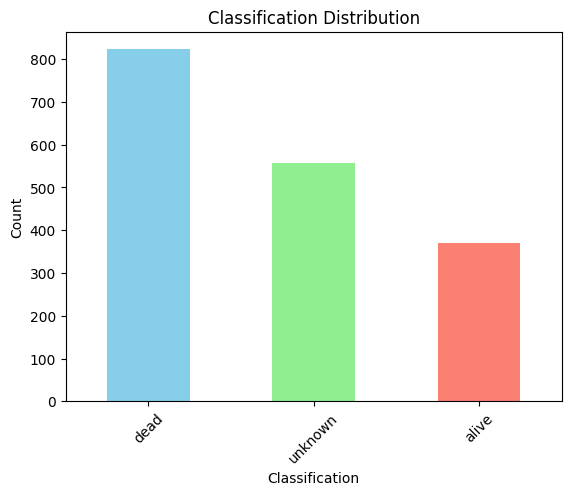

In [46]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [47]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,989884.80,1.588616,3.604448e+05,dead,858.443900
3,C_2d-inc_developer_quest,6848421.0,127440288.0,6099397.60,7.840104,1.944424e+06,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,11257996.40,30.371325,9.972051e+06,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,22938332.75,68.840289,1.124620e+07,dead,660.853056
11,C_academind_node-restful-api-tutorial,126883.0,192108057.0,120851.95,0.770515,8.529193e+04,dead,2223.472882
15,C_adamisntdead_QuSimPy,38543496.0,172234206.0,9791496.60,23.921428,7.437325e+06,dead,1993.451458
17,C_addyosmani_backbone-fundamentals,36341992.0,191057648.0,9445593.40,26.139278,6.996648e+06,dead,2211.315370
18,C_adiew-code_QQ,851273.0,249430357.0,703117.60,1.092355,2.316010e+05,dead,2886.925428
19,C_Advanced-Frontend_Daily-Interview-Question,13667537.0,99183181.0,7003078.80,14.897225,2.981791e+06,dead,1147.953484


In [50]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
296,C_deezertidal_QuantumultX-Rewrite,10529.0,328631.0,10493.6,0.083327,1.548371e+03,dead,3.803600
701,C_justjake_quickjs-emscripten,11138.0,379766.0,5176.4,0.012623,2.317841e+03,dead,4.395440
1440,C_singerdmx_flutter-quill,183188.0,390365.0,126271.0,0.239976,4.574458e+04,dead,4.518113
1236,C_quarkusio_quarkusio,172993.0,425682.0,138292.6,0.504397,4.654092e+04,dead,4.926875
1520,C_TanStack_query,161801.0,464829.0,145154.0,0.269876,4.715794e+04,dead,5.379965
...,...,...,...,...,...,...,...,...
1137,C_punkave_phpQuery,364.0,382092634.0,364.0,0.004213,NaN,dead,4422.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,385339174.0,5798779.8,18.357984,3.067312e+06,dead,4459.944144
570,C_huacnlee_quora,1575684.0,385840367.0,800899.2,1.889645,3.499387e+05,dead,4465.744988
1112,C_placemarker_jQuery-MD5,7546712.0,396091502.0,5972567.2,19.857190,2.504764e+06,dead,4584.392384


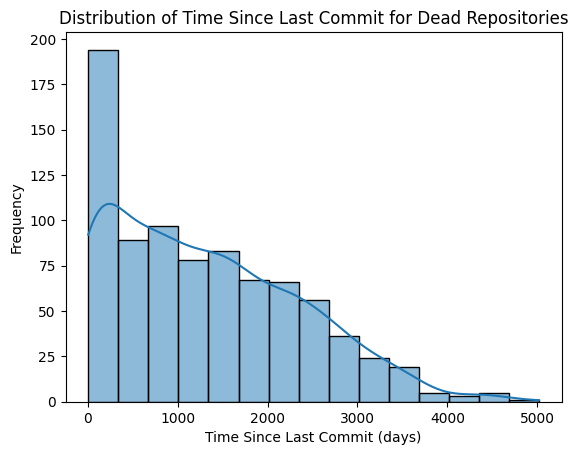

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


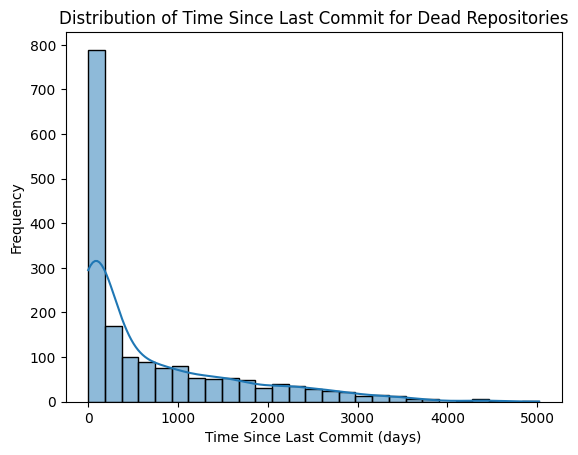

In [56]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [57]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)


,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,39589406.60,59.179903,1.511107e+07,alive,114.686644
5,C_78778443_QingScan,14194587.0,3143181.0,7234965.00,14.769794,3.217094e+06,alive,36.379410
6,C_89996462_Quantumult-X,596400.0,396044.0,517368.20,1.515934,1.816851e+05,alive,4.583843
8,C_aamirafridi_jQuery,64920542.0,31156632.0,38042486.60,64.752743,1.575285e+07,alive,360.609167
12,C_acmerobotics_road-runner-quickstart,1309024.0,609549.0,734764.20,2.928942,3.048245e+05,alive,7.054965
27,C_airbnb_lottie-android,4840517.0,1404002.0,2005791.40,5.603810,1.003013e+06,alive,16.250023
28,C_airbnb_lottie-ios,1547513.0,890655.0,1310913.80,3.378443,4.205420e+05,alive,10.308507
29,C_airbus-seclab_qemu_blog,24165616.0,5057537.0,21513684.25,57.757322,8.605990e+06,alive,58.536308
31,C_aizvorski_video-quality,118991936.0,4859445.0,84908819.60,196.208139,3.324118e+07,alive,56.243576
33,C_akullpp_awesome-java,8377543.0,3652060.0,6622214.00,9.389846,2.218849e+06,alive,42.269213


In [60]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
196,C_chentao0707_QrCodeScan,193643383.0,96135592.0,1.096517e+08,241.074126,6.076016e+07,alive,1112.680463
1593,C_udacity_ud843-QuakeReport,182957271.0,59138959.0,1.829573e+08,2117.561007,NaN,alive,684.478692
1511,C_ta-data-lis_lab-mysql-first-queries,82269216.0,55584758.0,6.170421e+07,158.716489,3.358550e+07,alive,643.342106
1579,C_tvvocold_How-To-Ask-Questions-The-Smart-Way,154258970.0,54412381.0,1.367203e+08,516.587500,6.758521e+07,alive,629.772928
1564,C_tomnomnom_qsreplace,82187479.0,48051981.0,7.026392e+07,245.615961,4.066405e+07,alive,556.157187
...,...,...,...,...,...,...,...,...
195,C_chengyangkj_Ros_Qt5_Gui_App,929405.0,219493.0,7.396384e+05,1.207126,2.457748e+05,alive,2.540428
1176,C_qdrant_quaterion,23259267.0,212763.0,3.458366e+06,18.933867,4.298579e+06,alive,2.462535
240,C_connamara_quickfixn,1756283.0,204059.0,4.097954e+05,1.340844,3.337473e+05,alive,2.361794
1161,C_qbcore-framework_qb-phone,6978492.0,191893.0,6.786414e+06,19.857457,2.219445e+06,alive,2.220984


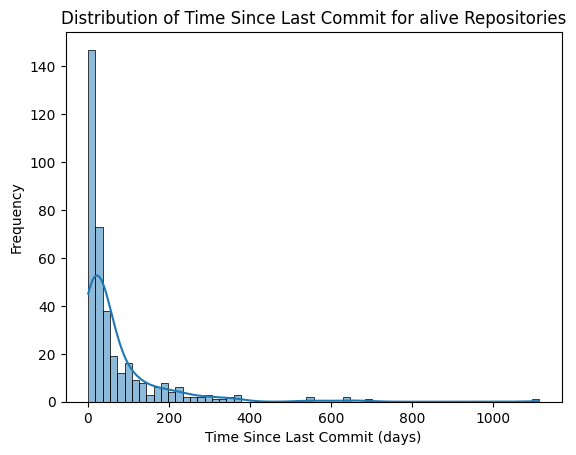

In [64]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

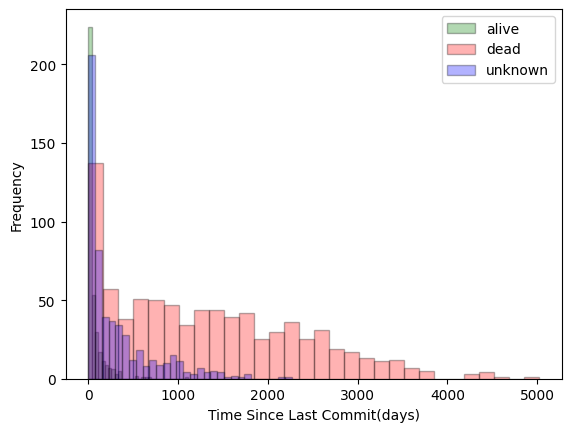

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Plotting
fig, ax = plt.subplots()
colors = {'alive': 'green', 'dead': 'red', 'unknown': 'blue'}  # Example classifications
for classification, color in colors.items():
    data = results_df[results_df['Classification'] == classification]['TimeSinceLastCommit(days)']
    ax.hist(data, bins=30, alpha=0.3, label=classification, color=color, edgecolor='black')

ax.set_xlabel('Time Since Last Commit(days)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


#### merge datasets

In [ ]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
